In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Segment image data using local thresholds

This notebook meshes an image with multiple domains using Nanomesh. The image contains a gradient from left to right.  If the image background is relatively uniform, global thresholds can be used to separate the different domains. In this case, the image has a contrast gradient from left to right, so this example shows three different methods to deal with this.

The image is then meshed using Nanomesh to obtain a mesh with multiple domains. The mesh contains triangles labeled as 'pore' or 'bulk' material.

### Loading and pre-processing the data

This example uses nanopore sample data from `nanomesh.data`. Notice how the image has a bit of a gradient going from top to bottom. We apply a gaussian filter to reduce image noise.

If you want to use your own data, any numpy array can be passed to into a [`Volume`](https://nanomesh.readthedocs.io/en/latest/nanomesh.volume.html#nanomesh.volume.Volume) object. Data stored as `.npy` can be loaded using `Volume.load()`.

<IPython.core.display.Javascript object>


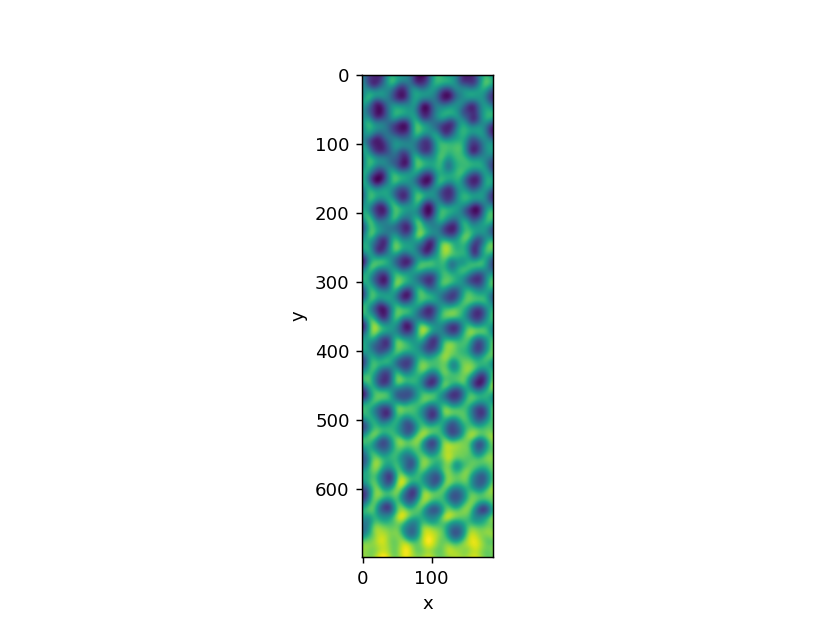

<AxesSubplot:xlabel='x', ylabel='y'>

In [2]:
from nanomesh import Plane
from nanomesh.data import nanopores_gradient

data = nanopores_gradient()

plane = Plane(data).gaussian(sigma=5)
plane.show()

Using `.try_all_thresholds` is usually a good way to find a useful value to segment the data. In this case, the gradient prevents us from getting a useful segmentation.

<IPython.core.display.Javascript object>


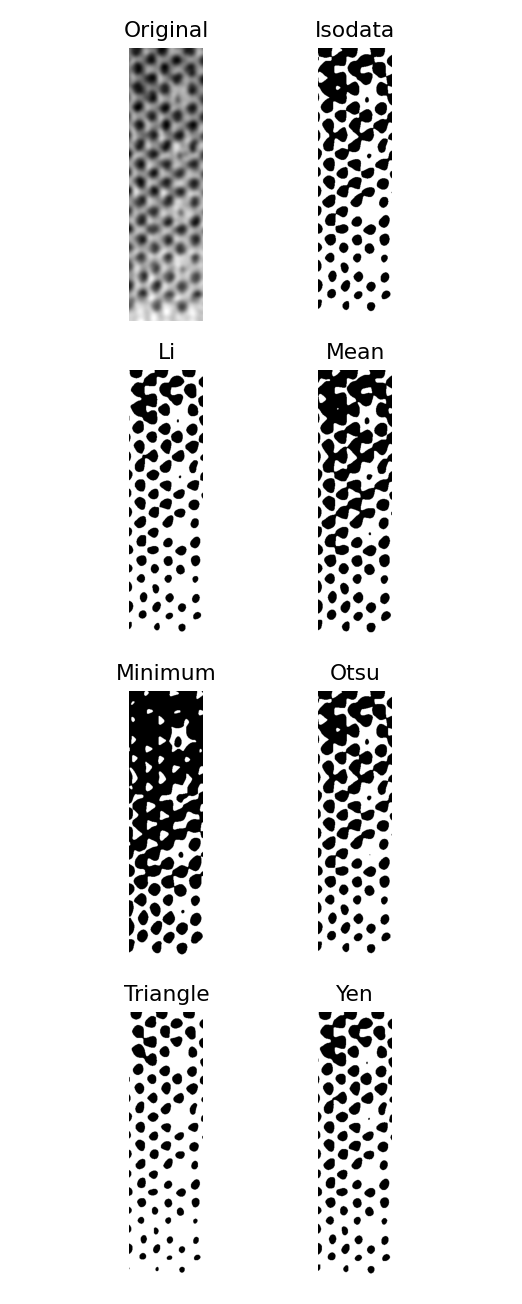

In [3]:
plane.try_all_threshold(figsize=(4, 10))

### Local thresholding

This section explores three different methods for local thresholding.

- User-defined local threshold ([api][1], [example][2])
- Otsu local threshold ([api][3], [example][4])
- Adaptive histogram equalization ([api][5], [example][6])

#### User-defined local threshold

In a local threshold filter, the local neighbourhoud is used to define a threshold map for the image. The `block_size` defines the size of the neighbourhood, a 101 by 101 pixel window in this case. The offset is used to tune the map. The advantage of this method is that it is fairly simple. The downside is that it requires manually tuning two parameters (`offset`, `blocksize`) to get a useful result.

[1]: https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_local  
[2]: https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html#local-thresholding
[3]: https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#skimage.filters.rank.otsu  
[4]: https://scikit-image.org/docs/stable/auto_examples/applications/plot_rank_filters.html#image-threshold
[5]: https://scikit-image.org/docs/stable/api/skimage.exposure.html#equalize-adapthist  
[6]: https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_local_equalize.html#local-histogram-equalization

<IPython.core.display.Javascript object>


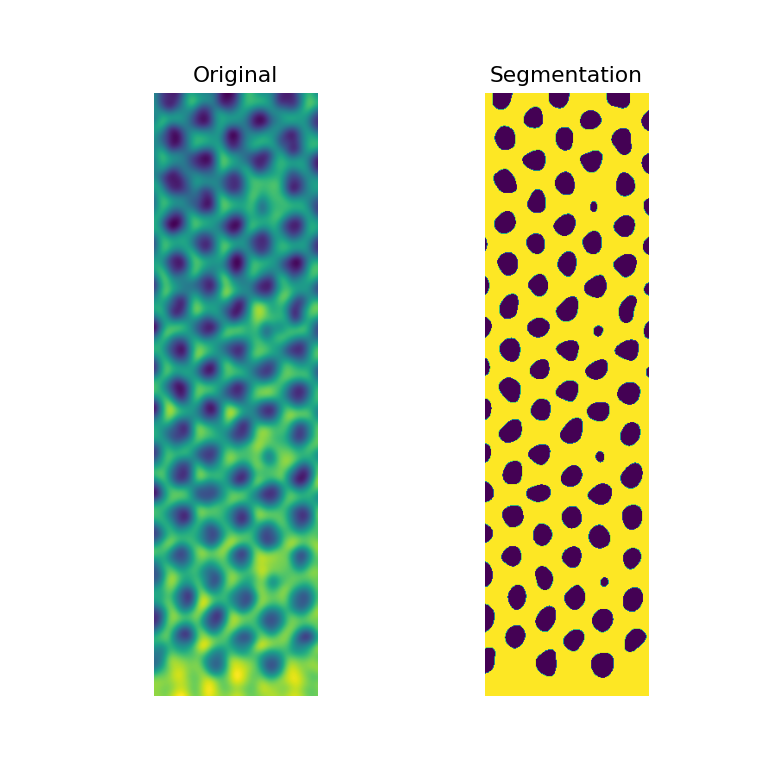

In [4]:
import matplotlib.pyplot as plt

offset = 150
block_size = 101

local_thresh = plane.threshold('local', block_size=block_size, offset=offset)
seg_local = plane > local_thresh

## Plot

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(plane.image)
ax[0].set_title('Original')

ax[1].imshow(seg_local.image)
ax[1].set_title('Segmentation')

for a in ax:
    a.axis('off')

plt.show()

#### Otsu local threshold

Applies an otsu rank filter to determine the local otsu threshold to segment on. Similar to the global otsu method, but constrained to a small area around each pixel. The advantage of this method that it only requires tuning a single parameter, namely the `radius` of the neighbourhood. The downside is that only the otsu method is available as a rank filter.

<IPython.core.display.Javascript object>


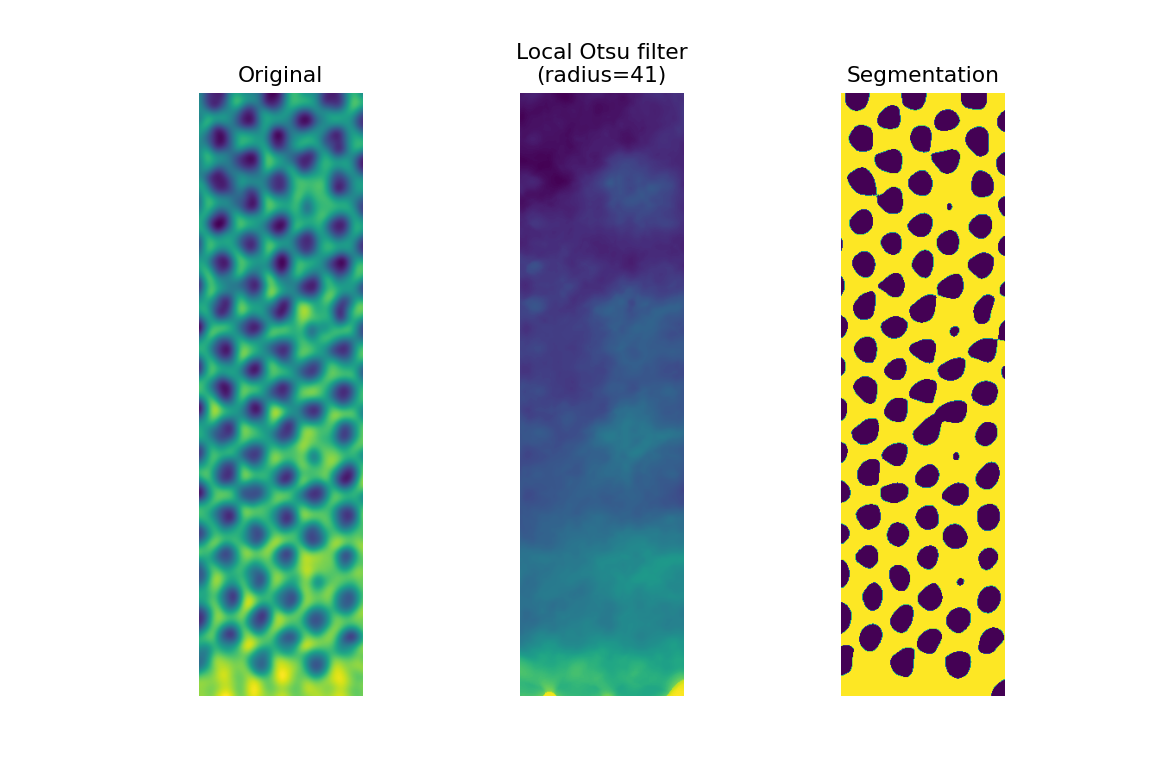

In [5]:
from skimage.morphology import disk
from skimage.filters import rank
from skimage.util import img_as_ubyte

plane_norm = plane.normalize_values().apply(img_as_ubyte)

radius = 41
selem = disk(radius)

local_otsu = plane_norm.apply(rank.otsu, selem=selem)
seg_local_otsu = plane_norm >= local_otsu

## Plot

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(9, 6))
axes = axes.ravel()

axes[0].imshow(plane.image)
axes[0].set_title('Original')

axes[1].imshow(local_otsu.image)
axes[1].set_title(f'Local Otsu filter\n(radius={radius})')

axes[2].imshow(seg_local_otsu.image)
axes[2].set_title('Segmentation')

for ax in axes:
    ax.axis('off')

plt.show()

#### Adaptive histogram equalization

This method tries to correct the image by removing the local gradient first, using adaptive histogram equalization. The advantage is that all global threshold finders are available. Another advantage is that there are no parameters to tune. At the same time, this is also a disadvantage if the result is not good 😉

<IPython.core.display.Javascript object>


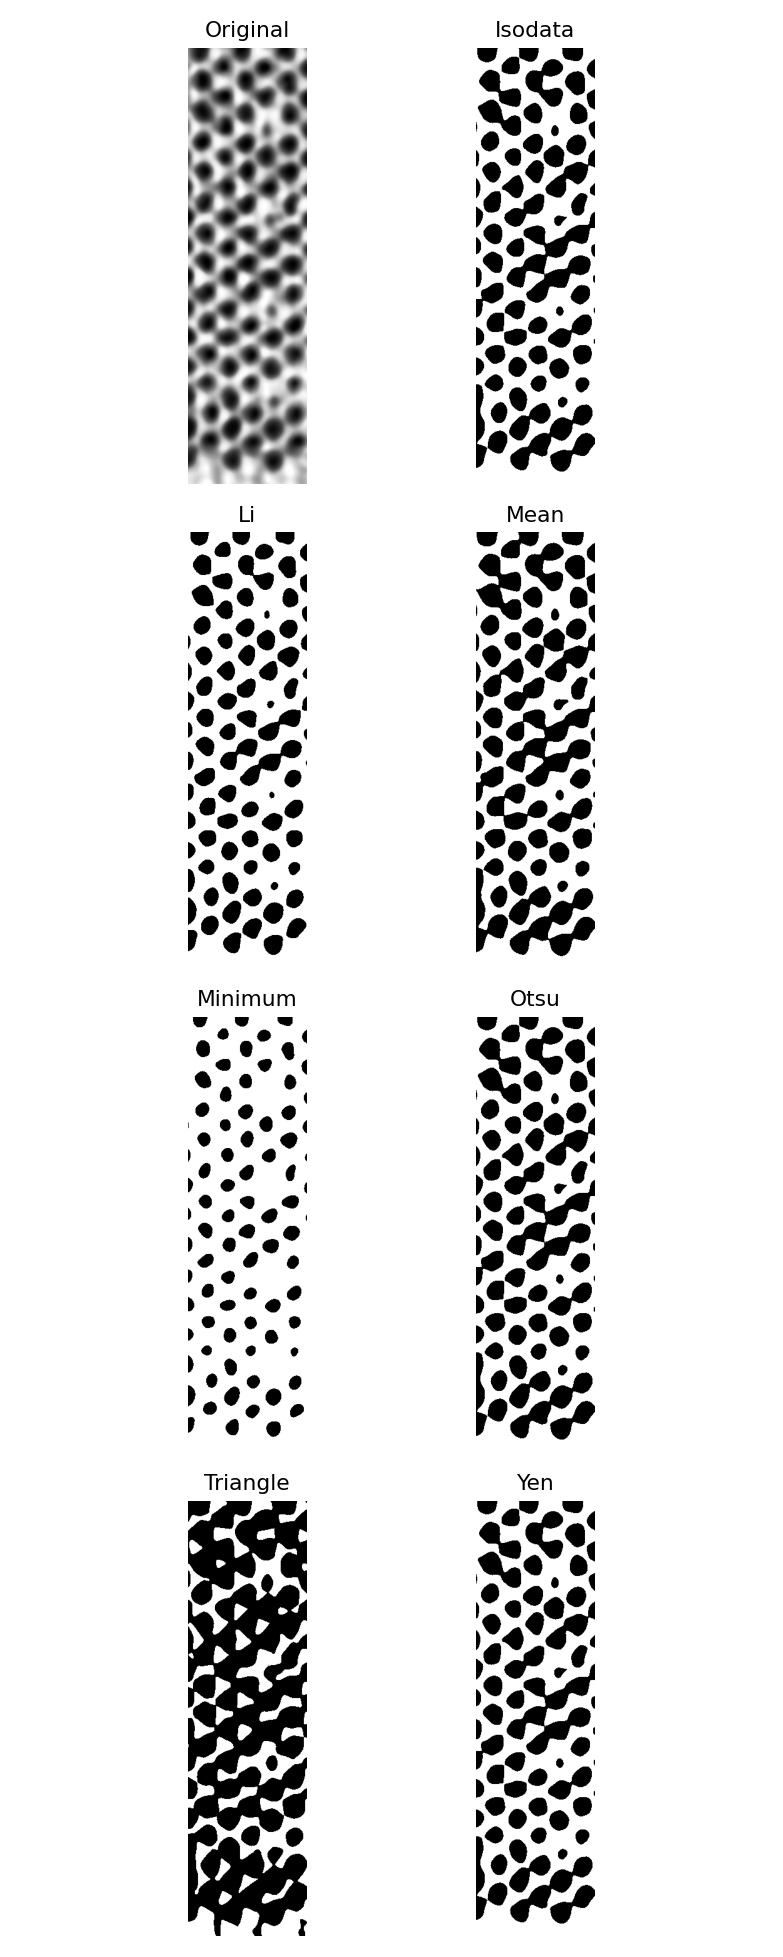

In [6]:
from skimage import exposure

plane_eq = plane.normalize_values()
plane_eq = plane_eq.apply(exposure.equalize_adapthist)

plane_eq.try_all_threshold(figsize=(6, 15))

### Compare results

The next cell creates a plot that compares the result of all three methods. For the histogram equalization, the *Otsu* and *Li* filters are shown.

<IPython.core.display.Javascript object>


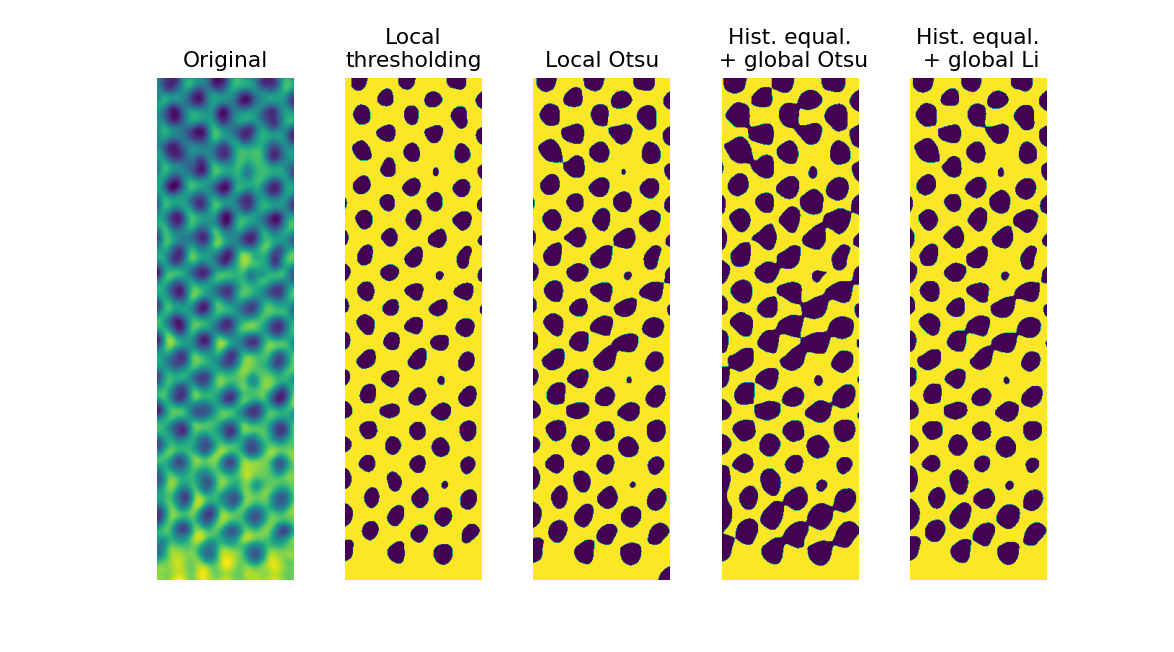

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=5, figsize=(9, 5))
axes = axes.ravel()

axes[0].imshow(plane.image)
axes[0].set_title('Original')

axes[1].imshow(seg_local.image)
axes[1].set_title('Local\nthresholding')

axes[2].imshow(seg_local_otsu.image)
axes[2].set_title('Local Otsu')

seg_clahe_otsu = plane_eq.binary_digitize(threshold='otsu')

axes[3].imshow(seg_clahe_otsu.image)
axes[3].set_title('Hist. equal.\n + global Otsu')

seg_clahe_li = plane_eq.binary_digitize(threshold='li')

axes[4].imshow(seg_clahe_li.image)
axes[4].set_title('Hist. equal.\n + global Li')

for ax in axes:
    ax.axis('off')

plt.show()

### Meshing the image data

Finally, it's time to mesh the image. 

<IPython.core.display.Javascript object>


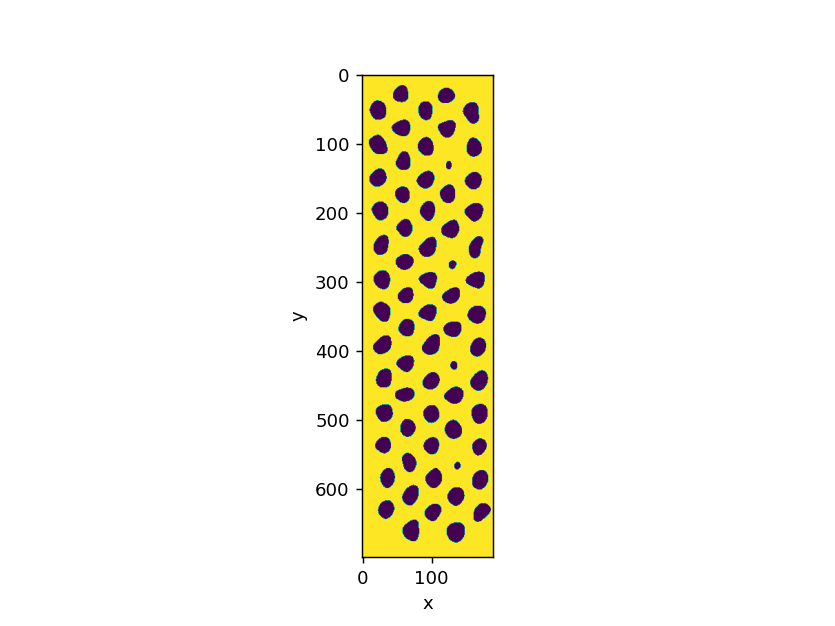

<AxesSubplot:xlabel='x', ylabel='y'>

In [8]:
# Triangulation has some issues with small elements near the border, 
# so these will be cleared first.
# https://github.com/hpgem/nanomesh/issues/86

seg_local = seg_local.clear_border(object_label=0, fill_val=1)
seg_local.show()

In [9]:
%%time

from nanomesh import Mesher2D

mesher = Mesher2D(seg_local)
mesher.generate_contour(max_contour_dist = 4)

mesh = mesher.triangulate(opts='q30a100')

Wall time: 138 ms


View the result using `matplotlib`:

<IPython.core.display.Javascript object>


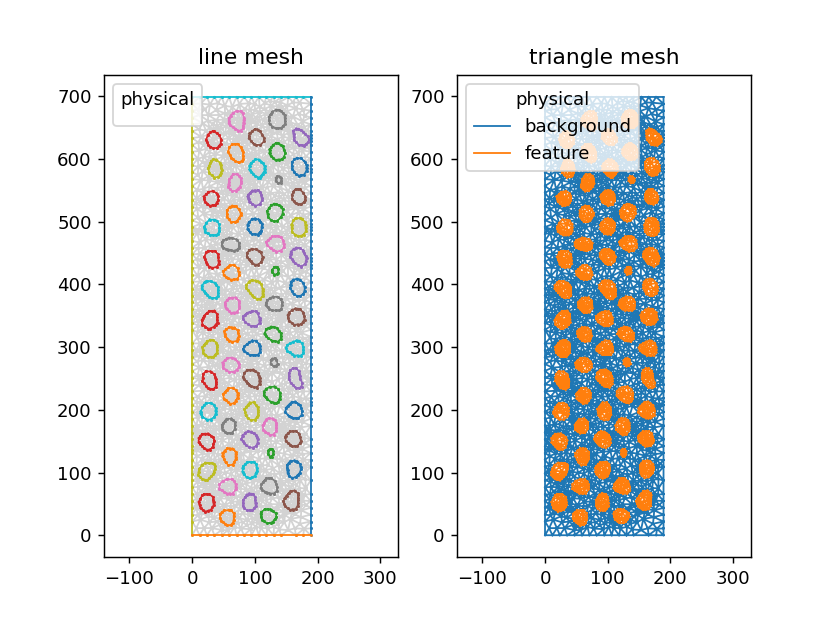

(<AxesSubplot:title={'center':'line mesh'}>,
 <AxesSubplot:title={'center':'triangle mesh'}>)

In [10]:
mesh.plot(color_map={0: 'lightgray'}, lw=1)

Or, view the result using pyvista:

(Note: Use `mesh.plot_itk()` for an interactive view).

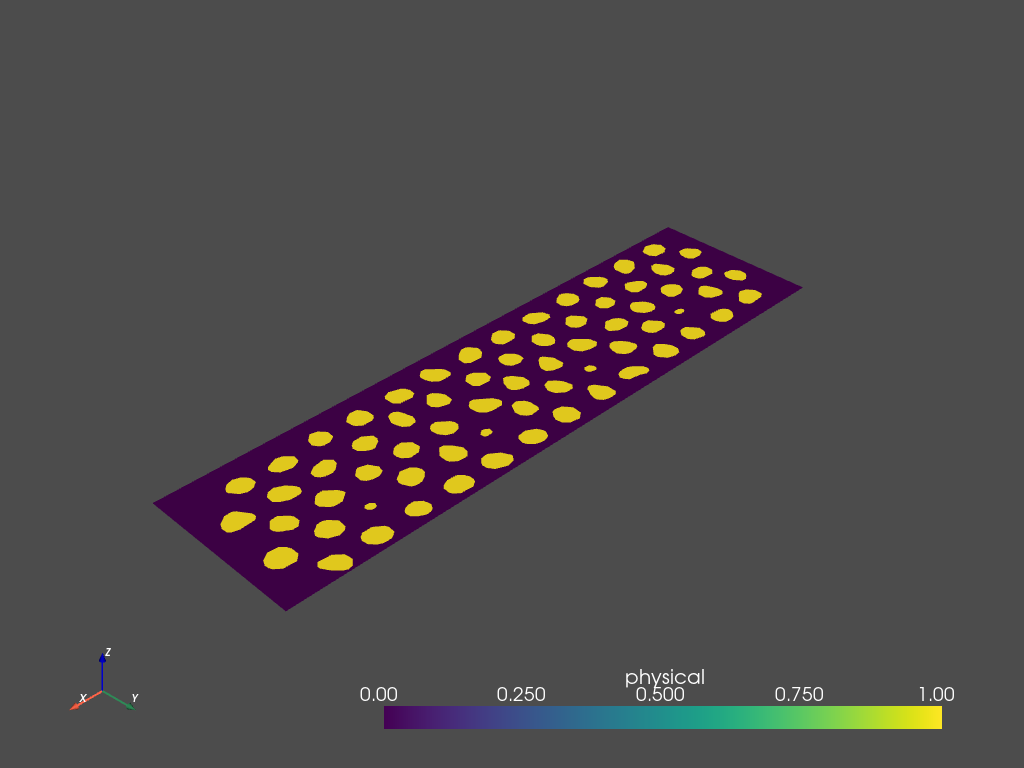

In [11]:
mesh.plot_pyvista(jupyter_backend='static', show_edges=False)

Save the data:

In [12]:
mesh.write("mesh_gradient.msh", file_format='gmsh22', binary=False)

Warning: Appending zeros to replace the missing geometrical tag data.